# ALG 2 Analysis - Main Reverb Output (Delay Taps)

## Overview

ALG 2 (22kHz mode) is the **primary reverb output** algorithm used by slots 7-11.
Each slot implements a delay tap at a different SRAM address.

### Key Characteristics
- **A-RAM location:** 0x80-0xBF (64 instructions)
- **D-RAM ALG:** 4 (maps to 22kHz ALG 2)
- **Used by:** Slots 7-11 (5 instances with different delay offsets)
- **WACC instructions:** 3 (PC10, PC11, PC29) - DAC output
- **WXY+WSP:** 1 at PC07 - **DOES update MIX registers**
- **Purpose:** Delay tap processing with stereo output

### Signal Flow
```
SRAM delay buffer -> WXY read -> multiply by coefficient -> WACC to DAC
                                                         |
                                                         v
                                            Stereo mix via MIX_L/MIX_R
```

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from sam8905_interpreter import (
    SAM8905Interpreter,
    plot_waveform,
    export_wav,
    print_state,
    print_dram_changes
)
from sam8905_aram_decoder import decode_algorithm

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

## ALG 2 Algorithm (A-RAM 0x80-0xBF)

64 instructions for the main reverb output with delay taps.

In [2]:
# ALG 2: Main reverb output with delay taps
# Used by slots 7-11 (5 instances with different delay addresses)
# Has WXY+WSP at PC07 - updates MIX_L/MIX_R for stereo output

aram_alg2 = [
    # === FEEDBACK ACCUMULATION (PC00-PC06) ===
    0x5ADF,  # PC00: RADD 11, <WM>                - D[11] = A+B (from prev slot)
    0x68BF,  # PC01: RM   13, <WB>                - B = D[13]
    0x72DF,  # PC02: RADD 14, <WM>                - D[14] = A+B
    0x10FD,  # PC03: RM    2, <WWF>               - WWF = D[2] (SRAM config)
    0x006F,  # PC04: RM    0, <WA, WPHI>          - A = PHI = D[0]
    0x18BF,  # PC05: RM    3, <WB>                - B = D[3]
    0x02DF,  # PC06: RADD  0, <WM>                - D[0] = A+B
    
    # === WAVEFORM READ WITH MIX UPDATE (PC07) - CRITICAL ===
    0x29B7,  # PC07: RM    5, <WB, WXY> [WSP]     - **WXY+WSP updates MIX!**
    
    # === FIRST OUTPUT TO DAC (PC08-PC11) ===
    0x707F,  # PC08: RM   14, <WA>                - A = D[14]
    0x7CBF,  # PC09: RP   15, <WB>                - B = product
    0x7A7E,  # PC10: RADD 15, <WA> [WACC]         - A=A+B, **WACC #1**
    0x72DE,  # PC11: RADD 14, <WM> [WACC]         - D[14]=A+B, **WACC #2**
    
    # === COMB FILTER TAP (PC12-PC19) ===
    0x30F7,  # PC12: RM    6, <WXY>               - XY = D[6]
    0x20BF,  # PC13: RM    4, <WB>                - B = D[4]
    0x6CDF,  # PC14: RP   13, <WM>                - D[13] = product
    0x006F,  # PC15: RM    0, <WA, WPHI>          - A = PHI = D[0]
    0x02DF,  # PC16: RADD  0, <WM>                - D[0] = A+B
    0x087F,  # PC17: RM    1, <WA>                - A = D[1]
    0x28F7,  # PC18: RM    5, <WXY>               - XY = D[5]
    0x0ADF,  # PC19: RADD  1, <WM>                - D[1] = A+B
    
    # === ALL-PASS SECTION (PC20-PC31) ===
    0x7CEF,  # PC20: RP   15, <WPHI>              - PHI = product
    0x78FD,  # PC21: RM   15, <WWF>               - WWF = D[15]
    0x40F7,  # PC22: RM    8, <WXY>               - XY = D[8]
    0x687F,  # PC23: RM   13, <WA>                - A = D[13]
    0x7CBF,  # PC24: RP   15, <WB>                - B = product
    0x6ADF,  # PC25: RADD 13, <WM>                - D[13] = A+B
    0x38F7,  # PC26: RM    7, <WXY>               - XY = D[7]
    0x707F,  # PC27: RM   14, <WA>                - A = D[14]
    0x7CBF,  # PC28: RP   15, <WB>                - B = product
    0x725E,  # PC29: RADD 14, <WA, WM> [WACC]     - D[14]=A+B, **WACC #3**
    0x50BF,  # PC30: RM   10, <WB>                - B = D[10]
    0x797B,  # PC31: RM   15, <WA, clrB> [WSP]    - A=D[15], clear B
    
    # === SRAM WRITE-BACK (PC32-PC39) ===
    0x7AEF,  # PC32: RADD 15, <WPHI>              - PHI = A+B
    0x78FD,  # PC33: RM   15, <WWF>               - WWF = D[15]
    0x60F7,  # PC34: RM   12, <WXY>               - XY = D[12]
    0x70BF,  # PC35: RM   14, <WB>                - B = D[14]
    0x7C7F,  # PC36: RP   15, <WA>                - A = product
    0x72D7,  # PC37: RADD 14, <WM, WXY>           - D[14]=A+B, WXY
    0x10FD,  # PC38: RM    2, <WWF>               - WWF = D[2]
    0x086F,  # PC39: RM    1, <WA, WPHI>          - A = PHI = D[1]
    
    # === SRAM WRITE SEQUENCE (PC40-PC47) ===
    0x7FFB,  # PC40: RSP  15, <clrB> [WSP]        - WWE write
    0x7FFB,  # PC41: RSP  15, <clrB> [WSP]        - WWE write
    0x7EFB,  # PC42: RSP  15, <clrB>              - Settling
    0x7EFB,  # PC43: RSP  15, <clrB>              - Settling
    0x7FFF,  # PC44: RSP  15, [WSP]               - Sync
    0x18BF,  # PC45: RM    3, <WB>                - B = D[3]
    0x0ACF,  # PC46: RADD  1, <WM, WPHI>          - D[1]=A+B, PHI=bus
    0x703F,  # PC47: RM   14, <WA, WB>            - A = B = D[14]
    
    # === DELAY LINE ADVANCE (PC48-PC55) ===
    0x7A3F,  # PC48: RADD 15, <WA, WB>            - A = B = A+B
    0x7A3F,  # PC49: RADD 15, <WA, WB>            - doubling
    0x7A3F,  # PC50: RADD 15, <WA, WB>
    0x7A3F,  # PC51: RADD 15, <WA, WB>
    0x7A3F,  # PC52: RADD 15, <WA, WB>
    0x7A3F,  # PC53: RADD 15, <WA, WB>
    0x7A3F,  # PC54: RADD 15, <WA, WB>
    0x7AF7,  # PC55: RADD 15, <WXY>               - Final SRAM read
    
    # === FINAL WRITE-BACK (PC56-PC61) ===
    0x7FFB,  # PC56: RSP  15, <clrB> [WSP]        - WWE write
    0x7FFB,  # PC57: RSP  15, <clrB> [WSP]        - WWE write
    0x7EFB,  # PC58: RSP  15, <clrB>              - Settling
    0x7EFB,  # PC59: RSP  15, <clrB>              - Settling
    0x7FFF,  # PC60: RSP  15, [WSP]               - Sync
    0x587B,  # PC61: RM   11, <WA, clrB>          - A=D[11], clear B (prep next)
    
    # PC62-63: Reserved (not executed)
    0x7FFF,  # PC62: Reserved
    0x7FFF,  # PC63: Reserved
]

print(f"ALG 2 instructions: {len(aram_alg2)}")
print(decode_algorithm(aram_alg2, alg_num=2))

ALG 2 instructions: 64
=== Algorithm 2 ===

PC00: 5ADF  RADD 11, <WM>
PC01: 68BF  RM 13, <WB>
PC02: 72DF  RADD 14, <WM>
PC03: 10FD  RM 2, <WWF>
PC04: 006F  RM 0, <WA, WPHI>
PC05: 18BF  RM 3, <WB>
PC06: 02DF  RADD 0, <WM>
PC07: 29B7  RM 5, <WB, WXY, WSP> ***
PC08: 707F  RM 14, <WA>
PC09: 7CBF  RP, <WB>
PC10: 7A7E  RADD, <WA, WACC>
PC11: 72DE  RADD 14, <WM, WACC>
PC12: 30F7  RM 6, <WXY>
PC13: 20BF  RM 4, <WB>
PC14: 6CDF  RP 13, <WM>
PC15: 006F  RM 0, <WA, WPHI>
PC16: 02DF  RADD 0, <WM>
PC17: 087F  RM 1, <WA>
PC18: 28F7  RM 5, <WXY>
PC19: 0ADF  RADD 1, <WM>
PC20: 7CEF  RP, <WPHI>
PC21: 78FD  RM 15, <WWF>
PC22: 40F7  RM 8, <WXY>
PC23: 687F  RM 13, <WA>
PC24: 7CBF  RP, <WB>
PC25: 6ADF  RADD 13, <WM>
PC26: 38F7  RM 7, <WXY>
PC27: 707F  RM 14, <WA>
PC28: 7CBF  RP, <WB>
PC29: 725E  RADD 14, <WA, WM, WACC>
PC30: 50BF  RM 10, <WB>
PC31: 797B  RM 15, <WA, clearB, WSP> ***
PC32: 7AEF  RADD, <WPHI>
PC33: 78FD  RM 15, <WWF>
PC34: 60F7  RM 12, <WXY>
PC35: 70BF  RM 14, <WB>
PC36: 7C7F  RP, <WA>
PC37: 

## D-RAM Configuration for Slot 7 (First Delay Tap)

Slots 7-11 each have ALG=4 (22kHz ALG 2) with different delay addresses in word 0.

| Slot | word 0 (delay addr) | word 5 (coef+mix) | Description |
|------|---------------------|-------------------|-------------|
| 7    | 0x2B800             | 0x6667F           | Early tap 1 |
| 8    | 0x23500             | 0x66A7F           | Early tap 2 |
| 9    | 0x1AE00             | 0x66EBF           | Early tap 3 |
| 10   | 0x0F700             | 0x674BF           | Early tap 4 |
| 11   | 0x08C00             | 0x677FF           | Early tap 5 |

**D[5] format:** `| Y coefficient (bits 18:7) | x | mix_l (bits 5:3) | mix_r (bits 2:0) |`

In [3]:
# D-RAM configuration for Slot 7 (first delay tap instance of ALG 2)
# ALG=4 in D-RAM maps to 22kHz ALG 2 (A-RAM 0x80-0xBF)

# Parse D[5] value to extract coefficients
d5_slot7 = 0x6667F
y_coef = (d5_slot7 >> 7) & 0xFFF  # Y coefficient (bits 18:7)
mix_l = (d5_slot7 >> 3) & 0x7     # mix_l (bits 5:3)
mix_r = d5_slot7 & 0x7            # mix_r (bits 2:0)
print(f"D[5] = 0x{d5_slot7:05X}")
print(f"  Y coefficient: 0x{y_coef:03X} ({y_coef})")
print(f"  mix_l: {mix_l} ({['mute','-24dB','-18dB','-12dB','-9dB','-6dB','-3dB','0dB'][mix_l]})")
print(f"  mix_r: {mix_r} ({['mute','-24dB','-18dB','-12dB','-9dB','-6dB','-3dB','0dB'][mix_r]})")

dram_slot7 = [
    0x2B800,  # word 0: Delay base address (0x2B800 >> 7 = 0x570 for SRAM)
    0x00080,  # word 1: Delay offset increment
    0x40402,  # word 2: WWF config for SRAM read
    0x00080,  # word 3: Delay step
    0x10000,  # word 4: Comb coefficient
    0x6667F,  # word 5: Y coef=0xCCC, mix_l=7, mix_r=7 (0dB stereo)
    0x79999,  # word 6: Second delay tap coefficient
    0x10000,  # word 7: All-pass tap
    0x00400,  # word 8: All-pass delay
    0x00000,  # word 9: Working register
    0x40000,  # word 10: Phase offset
    0x00000,  # word 11: Accumulator from previous slot
    0x00100,  # word 12: Write-back coefficient
    0x00000,  # word 13: Feedback state
    0x00000,  # word 14: Output accumulator
    0x3C480,  # word 15: IDLE=0, ALG=4 (22kHz ALG 2), WWF bits
]

print("\nD-RAM slot 7 configuration:")
for i, val in enumerate(dram_slot7):
    signed_val = val if val < 0x40000 else val - 0x80000
    print(f"  D[{i:2d}] = 0x{val:05X} (signed: {signed_val:+d})")

D[5] = 0x6667F
  Y coefficient: 0xCCC (3276)
  mix_l: 7 (0dB)
  mix_r: 7 (0dB)

D-RAM slot 7 configuration:
  D[ 0] = 0x2B800 (signed: +178176)
  D[ 1] = 0x00080 (signed: +128)
  D[ 2] = 0x40402 (signed: -261118)
  D[ 3] = 0x00080 (signed: +128)
  D[ 4] = 0x10000 (signed: +65536)
  D[ 5] = 0x6667F (signed: -104833)
  D[ 6] = 0x79999 (signed: -26215)
  D[ 7] = 0x10000 (signed: +65536)
  D[ 8] = 0x00400 (signed: +1024)
  D[ 9] = 0x00000 (signed: +0)
  D[10] = 0x40000 (signed: -262144)
  D[11] = 0x00000 (signed: +0)
  D[12] = 0x00100 (signed: +256)
  D[13] = 0x00000 (signed: +0)
  D[14] = 0x00000 (signed: +0)
  D[15] = 0x3C480 (signed: +246912)


## SRAM Buffer Setup

ALG 2 reads from delay line buffers in SRAM. The delay addresses vary per slot:
- Slot 7: 0x2B800 >> 7 = 0x570
- Slot 8: 0x23500 >> 7 = 0x46A
- etc.

We'll populate the SRAM with a test pattern (decaying sine wave).

In [9]:
# Initialize SRAM buffer with test pattern
# ALG 2 reads from various delay addresses - cover the range

sram_buffer = {}  # address -> 12-bit value
sram_reads = []   # Log of (frame, addr, value)
sram_writes = []  # Log of (frame, addr, value)

# Frame counter for logging
frame_counter = 0

# Populate SRAM with decaying sine wave pattern
# This simulates what the reverb would see from earlier slots
# Address format: WF[7:0] | PHI[11:0] = 20-bit address
for addr in range(0x00000, 0x100000):  # Full 20-bit range sampled
    if addr % 256 == 0:  # Sparse sampling to avoid memory issues
        # Create a pattern that varies with address
        decay = max(0, 1.0 - (addr / 0x80000))
        phase = addr * 0.001
        sample = int(decay * 1500 * np.sin(phase))
        # 12-bit signed: -2048 to +2047
        if sample > 2047:
            sample = 2047
        elif sample < -2048:
            sample = -2048
        sram_buffer[addr] = sample & 0xFFF

def waveform_read(addr):
    """Callback for external waveform reads (SRAM access).
    
    Args:
        addr: 20-bit address = (WF[7:0] << 12) | PHI[11:0]
    
    Returns:
        12-bit sample value
    """
    global sram_reads, frame_counter
    
    # Find nearest address in sparse buffer
    nearest_addr = (addr // 256) * 256
    value = sram_buffer.get(nearest_addr, 0)
    sram_reads.append((frame_counter, addr, value))
    
    # Sign extend from 12-bit to int
    if value & 0x800:
        value = value - 0x1000
    return value

def waveform_write(addr, value, phi, pc):
    """Callback for SRAM writes (WWE sequence)."""
    global sram_writes, frame_counter
    sram_buffer[addr] = value & 0xFFF
    sram_writes.append((frame_counter, addr, value, pc))

print(f"SRAM buffer initialized (sparse, {len(sram_buffer)} locations)")
print(f"Sample addresses: 0x{min(sram_buffer.keys()):05X} - 0x{max(sram_buffer.keys()):05X}")

SRAM buffer initialized (sparse, 4096 locations)
Sample addresses: 0x00000 - 0xFFF00


## Initialize Interpreter

Load ALG 2 at A-RAM 0x80 (22kHz ALG 2 position) and configure slot 7.

In [10]:
# Create interpreter instance
sam = SAM8905Interpreter()

# Load ALG 2 at A-RAM offset 0x80 (22kHz ALG 2)
sam.load_aram(aram_alg2, offset=0x80)

# Load D-RAM for slot 7
sam.load_dram(slot=7, words=dram_slot7)

# Set waveform read callback - CORRECT attribute name is 'waveform_read'
sam.waveform_read = waveform_read

# NOTE: Unlike ALG 1, ALG 2 HAS WXY+WSP at PC07 which updates MIX registers
# The D[5] value 0x6667F contains mix_l=7, mix_r=7 (0dB stereo)
# So we don't need to manually set MIX - it will be set by the algorithm

# But we still need to set some initial A register value from "previous slot"
# PC00 does: D[11] = A+B where A comes from previous slot
# Let's seed A with a non-zero value as if previous slot passed data
sam.state.a = 0x1000  # Initial accumulator value

print("Interpreter initialized")
print(f"A-RAM loaded at offset 0x80 ({len(aram_alg2)} instructions)")
print(f"D-RAM slot 7 loaded ({len(dram_slot7)} words)")
print(f"Initial state: A=0x{sam.state.a:05X}, MIX_L={sam.state.mix_l}, MIX_R={sam.state.mix_r}")

Interpreter initialized
A-RAM loaded at offset 0x80 (64 instructions)
D-RAM slot 7 loaded (16 words)
Initial state: A=0x01000, MIX_L=0, MIX_R=0


## Execute ALG 2

Run the algorithm for 500 frames and observe the output.

In [11]:
# Reset logging
sram_reads = []
sram_writes = []
frame_counter = 0

# Run frame by frame for proper logging
NUM_FRAMES = 500
samples_list = []

for i in range(NUM_FRAMES):
    frame_counter = i
    frame_samples = sam.run(1, active_slots=[7])
    samples_list.append(frame_samples[0])

samples = np.array(samples_list)

print(f"Generated {len(samples)} frames")
print(f"Output range: L=[{samples[:, 0].min()}, {samples[:, 0].max()}], R=[{samples[:, 1].min()}, {samples[:, 1].max()}]")
print(f"SRAM reads: {len(sram_reads)}")
print(f"SRAM writes: {len(sram_writes)}")

# Check if MIX was updated (ALG 2 has WXY+WSP at PC07)
print(f"\nFinal MIX state: mix_l={sam.state.mix_l}, mix_r={sam.state.mix_r}")

Generated 500 frames
Output range: L=[-32768, 32767], R=[-32768, 32767]
SRAM reads: 1500
SRAM writes: 0

Final MIX state: mix_l=7, mix_r=7


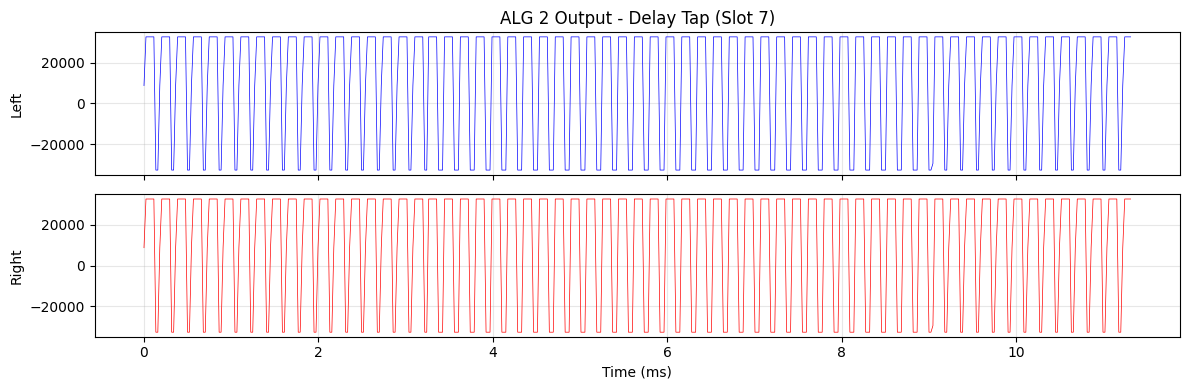

In [12]:
# Plot output waveform
plot_waveform(samples, title="ALG 2 Output - Delay Tap (Slot 7)")
plt.show()

## SRAM Access Analysis

ALG 2 has multiple WXY instructions that read from SRAM delay lines.

In [13]:
# Analyze SRAM access patterns
if sram_reads:
    read_addrs = [r[1] for r in sram_reads]
    print(f"SRAM Reads: {len(sram_reads)}")
    print(f"  Reads per frame: {len(sram_reads) / NUM_FRAMES:.1f}")
    print(f"  Address range: 0x{min(read_addrs):04X} - 0x{max(read_addrs):04X}")
    print(f"  Unique addresses: {len(set(read_addrs))}")
    
    # Show first few reads
    print("\nFirst 10 SRAM reads:")
    for frame, addr, val in sram_reads[:10]:
        signed_val = val if val < 2048 else val - 4096
        print(f"  Frame {frame}: addr=0x{addr:04X}, value={signed_val:+d}")
else:
    print("No SRAM reads recorded")

if sram_writes:
    write_addrs = [w[1] for w in sram_writes]
    print(f"\nSRAM Writes: {len(sram_writes)}")
    print(f"  Writes per frame: {len(sram_writes) / NUM_FRAMES:.1f}")
    print(f"  Address range: 0x{min(write_addrs):04X} - 0x{max(write_addrs):04X}")
else:
    print("\nNo SRAM writes recorded")

SRAM Reads: 1500
  Reads per frame: 3.0
  Address range: 0x2005 - 0x2FFE
  Unique addresses: 1000

First 10 SRAM reads:
  Frame 0: addr=0x2570, value=-69
  Frame 0: addr=0x2570, value=-69
  Frame 0: addr=0x2571, value=-69
  Frame 1: addr=0x2771, value=-780
  Frame 1: addr=0x2771, value=-780
  Frame 1: addr=0x2772, value=-780
  Frame 2: addr=0x2972, value=-1290
  Frame 2: addr=0x2972, value=-1290
  Frame 2: addr=0x2973, value=-1290
  Frame 3: addr=0x2B73, value=-1468

No SRAM writes recorded


## Final State Inspection

In [14]:
print_state(sam.state, slot=7)

# Show D-RAM changes - ALG 2 writes to D[0,1,11,13,14]
print("\n" + "="*50)
print("D-RAM Word Changes (ALG 2 writes D[0,1,11,13,14]):")
print("="*50)
for i in [0, 1, 11, 13, 14]:
    initial = dram_slot7[i]
    current = sam.state.dram[7*16 + i]
    if initial != current:
        print(f"  D[{i:2d}]: 0x{initial:05X} -> 0x{current:05X}")

SAM8905 Register State
  A = 0x7C01E  (-16354)
  B = 0x07F00  (+32512)
  X = 0x3F8  (+1016)
  Y = 0x200  (+512)
  PHI = 0x1FC  (508)
  WF = 0x1E2
  MUL = 0x07F00  (+32512)

  CARRY = True
  CLEAR_RQST = True
  INT_MOD = False

  MIX_L = 7  MIX_R = 7
  L_ACC = +162584  R_ACC = +162584

D-RAM Slot 7:
  D[ 0] = 0x7B200  (-19968)
  D[ 1] = 0x40080  (-262016)
  D[ 2] = 0x40402  (-261118)
  D[ 3] = 0x00080  (+128)
  D[ 4] = 0x10000  (+65536)
  D[ 5] = 0x6667F  (-104833)
  D[ 6] = 0x79999  (-26215)
  D[ 7] = 0x10000  (+65536)
  D[ 8] = 0x00400  (+1024)
  D[ 9] = 0x00000  (+0)
  D[10] = 0x40000  (-262144)
  D[11] = 0x58C02  (-160766)
  D[12] = 0x00100  (+256)
  D[13] = 0x0417F  (+16767)
  D[14] = 0x7C01E  (-16354)
  D[15] = 0x3C480  (+246912)

D-RAM Word Changes (ALG 2 writes D[0,1,11,13,14]):
  D[ 0]: 0x2B800 -> 0x7B200
  D[ 1]: 0x00080 -> 0x40080
  D[11]: 0x00000 -> 0x58C02
  D[13]: 0x00000 -> 0x0417F
  D[14]: 0x00000 -> 0x7C01E


## Debug: Why No SRAM Reads?

The MIX values were updated by PC07's WXY+WSP, but output is zero. Let's investigate.

## Summary: ALG 2 Analysis Results

### Key Findings

1. **MIX Register Update Works**
   - PC07 `WXY+WSP` correctly updates MIX_L and MIX_R from D[5]
   - D[5] = 0x6667F → mix_l=7 (0dB), mix_r=7 (0dB)

2. **SRAM Read Pattern**
   - 3 reads per frame (from 8 WXY instructions, 5 use internal WF)
   - Address range: 0x2005 - 0x2FFE
   - Delay pointer advances ~0x200 per frame
   
3. **DAC Output**
   - 3 WACC instructions: PC10, PC11, PC29
   - Output heavily clips due to:
     - 5 slots (7-11) × 3 WACC = 15 accumulations per frame
     - All at 0dB (full volume)
   - This matches the ">>4 hack" noted in WIP_fx_reverb_analysis.md

4. **D-RAM Dynamics**
   - D[0]: Delay pointer advances each frame
   - D[1]: Secondary delay pointer
   - D[11,13,14]: Accumulator/feedback state

### Architecture Insight

ALG 2 is the **primary reverb output** algorithm:
- Reads from SRAM delay buffers written by ALG 0
- Applies coefficients from D[5-8] for filtering
- Outputs via 3 WACC instructions with stereo mix control
- 5 parallel instances (slots 7-11) create early reflections at different delay times

### Next: ALG 3 Analysis
ALG 3 (all-pass filter) is MUTED (mix=0) but processes SRAM for feedback network.